In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


### Find 1der cells

In [3]:
adata_1der = sc.read_h5ad('/ix/djishnu/Yijia/project_asthma_lung/1_slide_tcr_seq/data/slideTCR_asthma_lymphnode_tangramAnno_wTCR_wRegion_w1DERCT_sample1_test.h5ad')
adata_1der

AnnData object with n_obs × n_vars = 27348 × 24457
    obs: 'n_counts', 'n_features', 'uniform_density', 'rna_count_based_density', 'celltype_label_tangram', 'celltype_label_tangram_MedFlexCT', 'celltype_label_tangram_LowFlexCT', 'has_tcr', 'has_TRA', 'has_TRB', 'aaSeqCDR3_A', 'aaSeqCDR3_B', 'TRA_clonotype', 'TRB_clonotype', 'final_region', '1DER', '1DER_cell_type'
    var: 'n_cells', 'sparsity'
    uns: 'final_region_colors', 'overlap_genes', 'training_genes'
    obsm: 'X_spatial', 'spatial', 'tangram_ct_pred'

In [4]:
adata_1der.obs.head(3)

n_counts  n_features  uniform_density  \
AAAAAAAAAAAATC      60.0          57         0.000037   
AAAAAAAACCAACA     106.0         101         0.000037   
AAAAAAAGCCAACA     147.0         130         0.000037   

                rna_count_based_density celltype_label_tangram  \
AAAAAAAAAAAATC                 0.000005              Resting T   
AAAAAAAACCAACA                 0.000008                      B   
AAAAAAAGCCAACA                 0.000011                      B   

               celltype_label_tangram_MedFlexCT  \
AAAAAAAAAAAATC                        Resting T   
AAAAAAAACCAACA                                B   
AAAAAAAGCCAACA                                B   

               celltype_label_tangram_LowFlexCT  has_tcr  has_TRA  has_TRB  \
AAAAAAAAAAAATC                        Resting T    False    False    False   
AAAAAAAACCAACA                                B    False    False    False   
AAAAAAAGCCAACA                                B    False    False    False   

               aaSeqCDR3_A aaSeqCDR3_B TRA_clonotype TRB_clonotype  \
AAAAAAAAAAAATC         NaN         NaN           NaN           NaN   
AAAAAAAACCAACA         NaN         NaN           NaN           NaN   
AAAAAAAGCCAACA         NaN         NaN           NaN           NaN   

               final_region   1DER 1DER_cell_type  
AAAAAAAAAAAATC   Bcell zone  False            NaN  
AAAAAAAACCAACA   Bcell zone  False            NaN  
AAAAAAAGCCAACA   Bcell zone  False            NaN

In [5]:
adata_train = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata_train.obs.head(3)

cell_type cell_type_int celltype_label_tangram
GGAAAACCCCGAGG    CD8+ T             1                 CD8+ T
TTTTTTACATCATC      Treg             6               B | Treg
TCAAGGAATGTGCT         B             0                      B

In [6]:
banksy = pd.read_csv('banksy_cluster.csv', index_col=0)
adata_train.obs['banksy_celltypes'] = banksy['banksy_cluster'].astype(str)

In [7]:
adata_train

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

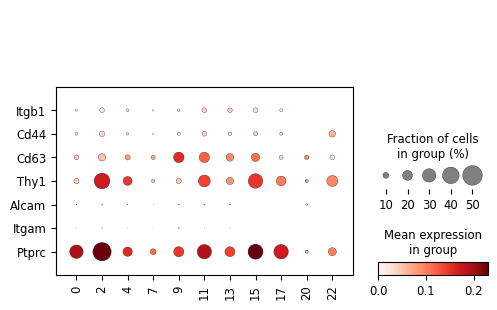

In [8]:
mouse_markers = [
    # MSC and stromal markers
    "Itgb1",     # CD29
    "Cd44",      # CD44
    "Cd63",      # CD63
    "Thy1",      # CD90
    "Alcam",     # CD166

    # Negative markers (should be low/absent in MSCs)
    "Itgam",     # CD11b
    "Ptprc",     # CD45
    "H2-Aa"      # HLA-DR (use H2-Aa or H2-Ab1 for mouse MHC class II)
]

markers = [x for x in mouse_markers if x in adata_train.var_names]
sc.pl.dotplot(adata_train, groupby='banksy_celltypes', var_names=markers, swap_axes=True)

In [9]:
shared = set(adata_train.obs_names) & set(adata_1der.obs_names)
len(shared)

21819

In [10]:
transferred = adata_1der[adata_1der.obs['1DER'] == True].obs_names
transferred

Index(['AAAACCGACCGAAT', 'AAACCCTGGTAGTT', 'AAACTGTCCCTCCA', 'AAAGCCCCGTTTAT',
       'AAAGCTACCGCGCT', 'AAAGTCTGGCCCCC', 'AAATCCGTGACCCC', 'AAATGTTGCTTCTT',
       'AACAACAGTGCTTC', 'AACAATTGTCAAAC',
       ...
       'TTGTTATAACTAGT', 'TTGTTTCCCCGCTA', 'TTTATTGCGCCAGA', 'TTTGATCAGCTCAG',
       'TTTGGCCATTTACT', 'TTTGTCTTGAACCG', 'TTTTAACGTGATCA', 'TTTTCGCGCCTCGA',
       'TTTTTGCAGGATGC', 'TTTTTTGTTTTCTA'],
      dtype='object', length=728)

In [11]:
adata_train.obs['1DER'] = adata_train.obs_names.isin(transferred)

transferred = adata_train.obs_names[adata_train.obs['1DER']].tolist() # some cells were filtered out

adata_train.obs['1DER_cell_type'] = adata_train.obs['cell_type'].copy().astype(str)
adata_train.obs.loc[transferred, '1DER_cell_type'] = adata_1der.obs.loc[transferred, '1DER_cell_type'].astype(str)
adata_train.obs['1DER'].value_counts()


1DER
False    21597
True       630
Name: count, dtype: int64

In [12]:
adata_1der.obs.loc[transferred, '1DER_cell_type'].value_counts()

1DER_cell_type
1DER Th2 day3          242
1DER Tfh day3          229
1DER Treg day3         131
1DER early Tfh day3     28
Name: count, dtype: int64

In [13]:
data = pd.concat(
        [pd.DataFrame(adata_train.obsm['spatial'], index=adata_train.obs_names, columns=['x', 'y']), 
        adata_train.obs], 
    axis=1)

data.head()

x            y cell_type cell_type_int  \
GGAAAACCCCGAGG -2556.053197  3508.755918    CD8+ T             1   
TTTTTTACATCATC -2019.251653  2629.533970      Treg             6   
TCAAGGAATGTGCT -1807.333103  3613.490513         B             0   
CGATGTGAATCTAC -1202.635325  3389.521116         B             0   
CATCGGACTAGCCC -1500.575367  4214.955137         B             0   

               celltype_label_tangram banksy_celltypes   1DER 1DER_cell_type  
GGAAAACCCCGAGG                 CD8+ T                4  False         CD8+ T  
TTTTTTACATCATC               B | Treg               11  False           Treg  
TCAAGGAATGTGCT                      B                4  False              B  
CGATGTGAATCTAC                      B                0  False              B  
CATCGGACTAGCCC                      B                0  False              B

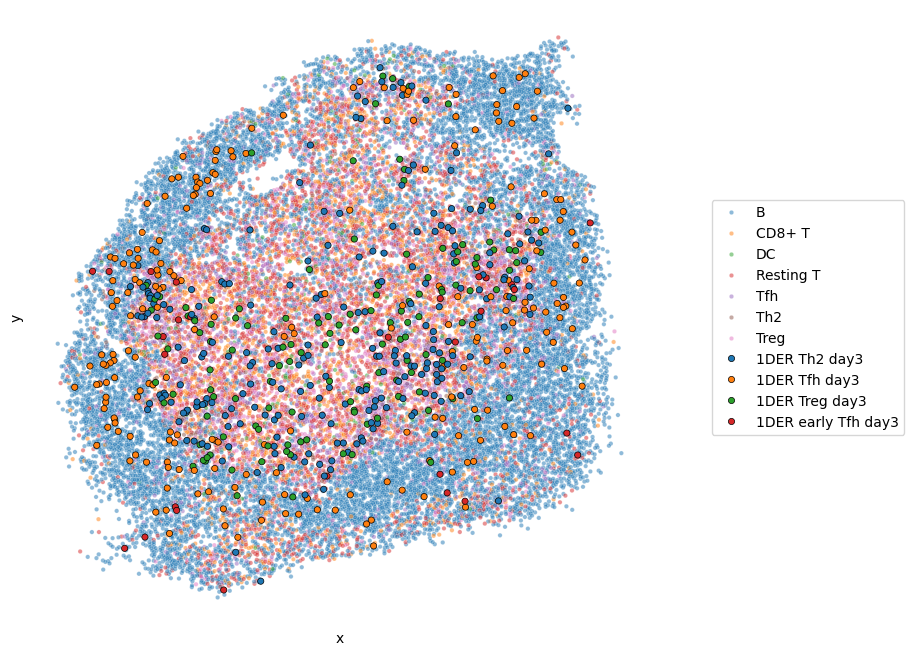

In [143]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    data=data,
    x='x', y='y',
    hue='cell_type',
    alpha=0.5,
    s=10,
    ax=ax,
)

sns.scatterplot(
    data=data.loc[transferred],
    x='x', y='y',
    hue='1DER_cell_type',
    alpha=1, edgecolor='black',
    linewidth=0.5,
    s=20,
    ax=ax,
)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0)
plt.show()

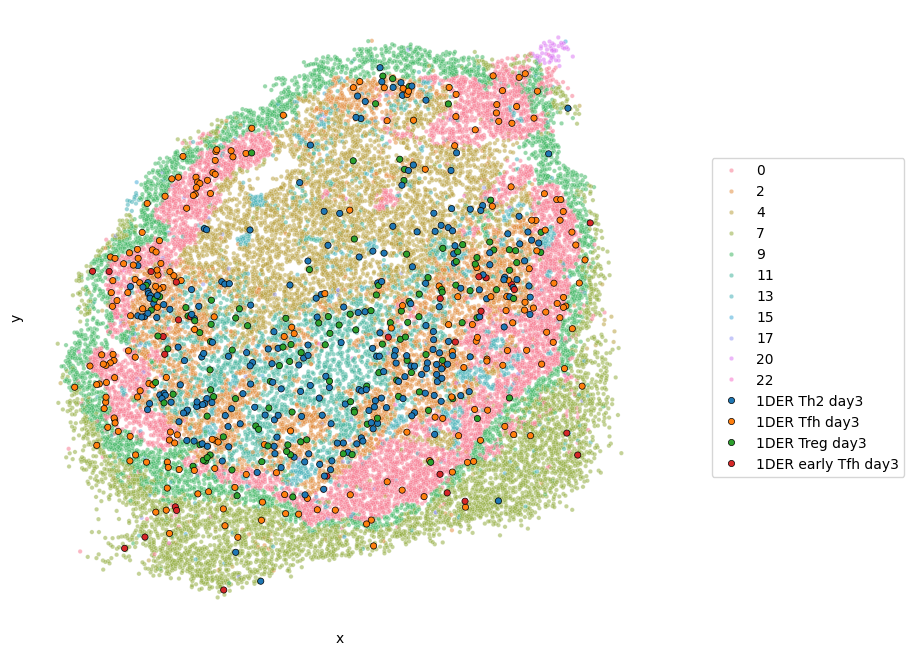

In [144]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    data=data,
    x='x', y='y',
    hue='banksy_celltypes',
    alpha=0.5,
    s=10,
    ax=ax,
)

sns.scatterplot(
    data=data.loc[transferred],
    x='x', y='y',
    hue='1DER_cell_type',
    alpha=1, edgecolor='black',
    linewidth=0.5,
    s=20,
    ax=ax,
)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0)
plt.show()

In [16]:
# sc.pp.pca(adata_train)

In [17]:
# sc.pp.neighbors(adata_train, n_neighbors=15, use_rep='X_pca')
# sc.tl.umap(adata_train)

In [18]:
# coords = pd.DataFrame(adata_train.obsm['X_spatial'], index=adata_train.obs_names, columns=['spatial_x', 'spatial_y'])
# coords = coords.join(pd.DataFrame(adata_train.obsm['X_umap'], index=adata_train.obs_names, columns=['umap_x', 'umap_y']))
# coords['cell_type'] = adata_train.obs['cell_type']
# coords.head(3)

In [19]:
# import seaborn as sns 
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# sns.scatterplot(
#     data=coords,
#     x='spatial_x', y='spatial_y',
#     hue='cell_type',
#     ax=axs[0],
#     s=10

# )
# sns.scatterplot(
#     data=coords.loc[adata_train[adata_train.obs['1DER'] == True].obs_names],
#     x='spatial_x', y='spatial_y',
#     color='red',
#     edgecolor='black',
#     ax=axs[0],
#     s=10
# )
# axs[0].set_title('Spatial')

# sns.scatterplot(
#     data=coords,
#     x='umap_x', y='umap_y',
#     hue='cell_type',
#     ax=axs[1],
#     s=10
# )

# sns.scatterplot(
#     data=coords.loc[adata_train[adata_train.obs['1DER'] == True].obs_names],
#     x='umap_x', y='umap_y',
#     color='red',
#     ax=axs[1],
#     edgecolor='black',
#     s=10
# )
# axs[1].set_title('UMAP')

# plt.suptitle('1DER cell locations')

### Perturb

In [14]:
import sys 
sys.path.append('../../src')

In [15]:
from spaceoracle import SpaceTravLR

from spaceoracle.tools.network import RegulatoryFactory
from spaceoracle.gene_factory import GeneFactory

2025-07-01 22:40:03.624667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [16]:
base_dir = '/ix/djishnu/shared/djishnu_kor11/training_data_2025/'

co_grn = RegulatoryFactory(
    colinks_path=base_dir + 'slideseq_mouse_lymphnode_colinks.pkl',
    annot='cell_type_int'
)

adata = sc.read_h5ad(f'{base_dir}slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [17]:
base_dir = '/ix/djishnu/shared/djishnu_kor11/'
betadir = base_dir + 'lasso_runs/slideseq_mouse_lymphnode/'
gf = GeneFactory.from_json(
    adata, 
    betadir + 'run_params.json', 
    override_params={'save_dir': betadir}
)

In [18]:
gf.load_betas(subsample=None, float16=True)

In [20]:
# simulated_gex = gf.perturb(
#     target='Ccr4',
#     n_propagation=4,
#     gene_expr=0,
#     cells=np.where(adata_train.obs['1DER'] == True)[0],
# )

simulated_gex = gf.perturb(
    target=['Ccr4', 'Ddit3'],
    n_propagation=4,
    gene_expr=[0, 0],
    cells=np.where(adata_train.obs['1DER'] == True)[0],
)
simulated_gex.shape


AssertionError: 

### Load perturbed df

In [148]:
# simulated_gex.to_parquet('/ix/djishnu/shared/djishnu_kor11/genome_screens/slideseq_mouse_lymphnode/Ccr4_4n_0x_1der.parquet')
simulated_gex.to_parquet('/ix/djishnu/shared/djishnu_kor11/genome_screens/slideseq_mouse_lymphnode/Ccr4-Irf1_4n_0x_1der.parquet')

# simulated_gex = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/genome_screens/slideseq_mouse_lymphnode/Ccr4_4n_0x_1der.parquet')
# simulated_gex = pd.read_parquet('/ix/djishnu/shared/djishnu_kor11/genome_screens/slideseq_mouse_lymphnode/Ccr6_4n_0x_1der.parquet')

In [149]:
adata_train.layers['simulated_count'] = simulated_gex.loc[adata_train.obs_names, adata_train.var.index].values
adata_train.layers['simulated_count'].shape

(22227, 3128)

In [150]:
delta_X = simulated_gex - adata_train.to_df(layer='imputed_count')
delta_X.head(3)

Adal  Adam11  Adamts1  Adamts12  Adamts15  Adamtsl1  Adat2  \
Ccr4_4n_0x                                                                   
GGAAAACCCCGAGG   0.0     0.0      0.0       0.0       0.0       0.0    0.0   
TTTTTTACATCATC   0.0     0.0      0.0       0.0       0.0       0.0    0.0   
TCAAGGAATGTGCT   0.0     0.0      0.0       0.0       0.0       0.0    0.0   

                       Adck2  Adcy4        Adgra2  ...  Zkscan6  Zkscan7  \
Ccr4_4n_0x                                         ...                     
GGAAAACCCCGAGG  0.000000e+00    0.0  0.000000e+00  ...      0.0      0.0   
TTTTTTACATCATC -1.758123e-11    0.0  0.000000e+00  ...      0.0      0.0   
TCAAGGAATGTGCT  0.000000e+00    0.0  3.851797e-13  ...      0.0      0.0   

                       Zmym4        Zmynd8  Znrd1as  Zranb1        Zranb2  \
Ccr4_4n_0x                                                                  
GGAAAACCCCGAGG  0.000000e+00  3.341806e-12      0.0     0.0  2.249624e-12   
TTTTTTACATCATC  0.000000e+00 -5.187179e-11      0.0     0.0 -9.226899e-11   
TCAAGGAATGTGCT -1.838039e-13 -6.948088e-13      0.0     0.0  0.000000e+00   

                Zswim5        Zswim6        Zyg11b  
Ccr4_4n_0x                                          
GGAAAACCCCGAGG     0.0 -2.253118e-07  1.027516e-11  
TTTTTTACATCATC     0.0 -4.549000e-07  0.000000e+00  
TCAAGGAATGTGCT     0.0  0.000000e+00  0.000000e+00  

[3 rows x 3128 columns]

In [151]:
# make sure it's knocked out
simulated_gex.loc[adata_train.obs['1DER'] == True, 'Ccr4'].sum(axis=0)

0.0

### Look at KO'ed cells

In [57]:
cois = simulated_gex.loc[transferred]
cois.head(3)

Adal    Adam11   Adamts1  Adamts12  Adamts15  Adamtsl1  \
Ccr4_4n_0x                                                                   
CGACCCCGGGTTGA  0.001224  0.000759  0.000915  0.000037  0.000057  0.000003   
CGAGGCGTGGTCTC  0.008090  0.000694  0.000774  0.001454  0.000038  0.000129   
TATAGAAGTCAGAG  0.001600  0.000918  0.000195  0.000061  0.000016  0.000028   

                   Adat2     Adck2     Adcy4    Adgra2  ...   Zkscan6  \
Ccr4_4n_0x                                              ...             
CGACCCCGGGTTGA  0.002565  0.001079  0.003254  0.015842  ...  0.004858   
CGAGGCGTGGTCTC  0.001009  0.003163  0.002171  0.000850  ...  0.003159   
TATAGAAGTCAGAG  0.000970  0.001326  0.001086  0.000190  ...  0.004528   

                 Zkscan7     Zmym4    Zmynd8   Znrd1as    Zranb1    Zranb2  \
Ccr4_4n_0x                                                                   
CGACCCCGGGTTGA  0.003440  0.004510  0.018869  0.000676  0.009100  0.017815   
CGAGGCGTGGTCTC  0.000867  0.005728  0.030442  0.002655  0.010027  0.027195   
TATAGAAGTCAGAG  0.000531  0.006390  0.020690  0.003751  0.007156  0.024015   

                  Zswim5    Zswim6    Zyg11b  
Ccr4_4n_0x                                    
CGACCCCGGGTTGA  0.000295  0.016141  0.008773  
CGAGGCGTGGTCTC  0.000065  0.006877  0.008067  
TATAGAAGTCAGAG  0.000523  0.010382  0.009756  

[3 rows x 3128 columns]

In [58]:
delta_coi = delta_X.loc[transferred]
delta_coi['cell_type'] = adata_train.obs.loc[transferred, '1DER_cell_type']

delta_coi.head(3)

Adal  Adam11  Adamts1  Adamts12  Adamts15  Adamtsl1  Adat2  \
Ccr4_4n_0x                                                                   
CGACCCCGGGTTGA   0.0     0.0      0.0       0.0       0.0       0.0    0.0   
CGAGGCGTGGTCTC   0.0     0.0      0.0       0.0       0.0       0.0    0.0   
TATAGAAGTCAGAG   0.0     0.0      0.0       0.0       0.0       0.0    0.0   

                Adck2  Adcy4        Adgra2  ...  Zkscan7         Zmym4  \
Ccr4_4n_0x                                  ...                          
CGACCCCGGGTTGA    0.0    0.0  6.165901e-14  ...      0.0 -4.984728e-14   
CGAGGCGTGGTCTC    0.0    0.0  2.057677e-13  ...      0.0 -1.404840e-13   
TATAGAAGTCAGAG    0.0    0.0  1.159972e-12  ...      0.0 -7.086640e-13   

                      Zmynd8  Znrd1as  Zranb1  Zranb2  Zswim5  Zswim6  Zyg11b  \
Ccr4_4n_0x                                                                      
CGACCCCGGGTTGA -2.791031e-13      0.0     0.0     0.0     0.0     0.0     0.0   
CGAGGCGTGGTCTC -6.414314e-13      0.0     0.0     0.0     0.0     0.0     0.0   
TATAGAAGTCAGAG -1.948396e-12      0.0     0.0     0.0     0.0     0.0     0.0   

                    cell_type  
Ccr4_4n_0x                     
CGACCCCGGGTTGA  1DER Th2 day3  
CGAGGCGTGGTCTC  1DER Tfh day3  
TATAGAAGTCAGAG  1DER Tfh day3  

[3 rows x 3129 columns]

In [59]:
delta_coi = (delta_X / adata_train.to_df(layer='imputed_count')).loc[transferred]
delta_coi['cell_type'] = adata_train.obs.loc[transferred, '1DER_cell_type']

genes_coi = delta_coi.groupby(by='cell_type').sum()
genes_coi

Adal  Adam11       Adamts1  Adamts12  Adamts15  Adamtsl1  \
cell_type                                                                       
1DER Tfh day3         0.0     0.0  3.795876e-11       0.0       0.0       0.0   
1DER Th2 day3         0.0     0.0 -7.852458e-12       0.0       0.0       0.0   
1DER Treg day3        0.0     0.0 -3.956404e-11       0.0       0.0       0.0   
1DER early Tfh day3   0.0     0.0  2.049146e-11       0.0       0.0       0.0   

                     Adat2     Adck2     Adcy4        Adgra2  ...  \
cell_type                                                     ...   
1DER Tfh day3          0.0 -0.000024 -0.000004  3.953370e-07  ...   
1DER Th2 day3          0.0 -0.000099 -0.000035  6.429385e-09  ...   
1DER Treg day3         0.0 -0.000026 -0.000005  5.533512e-08  ...   
1DER early Tfh day3    0.0  0.000000  0.000000  3.944248e-08  ...   

                          Zkscan6  Zkscan7         Zmym4        Zmynd8  \
cell_type                                                                
1DER Tfh day3       -4.800421e-05      0.0 -2.221125e-06 -1.733986e-06   
1DER Th2 day3       -1.170876e-04      0.0 -5.826622e-06 -8.758823e-06   
1DER Treg day3      -4.154025e-05      0.0 -2.373338e-06 -2.618397e-06   
1DER early Tfh day3  1.724651e-07      0.0 -6.083265e-09 -3.431090e-08   

                     Znrd1as    Zranb1        Zranb2  Zswim5    Zswim6  \
cell_type                                                                
1DER Tfh day3            0.0 -0.000777 -3.596990e-07     0.0 -0.000796   
1DER Th2 day3            0.0 -0.003253 -1.643258e-06     0.0 -0.001717   
1DER Treg day3           0.0 -0.001262 -5.921128e-07     0.0 -0.000968   
1DER early Tfh day3      0.0 -0.000077 -8.856960e-08     0.0  0.000032   

                           Zyg11b  
cell_type                          
1DER Tfh day3        1.955818e-08  
1DER Th2 day3        1.310103e-07  
1DER Treg day3       6.498000e-08  
1DER early Tfh day3  5.141336e-09  

[4 rows x 3128 columns]

In [60]:
# Get top 10 genes with largest absolute changes for each cell type
top_10_per_celltype = pd.DataFrame()
for cell_type in delta_coi['cell_type'].unique():
    cell_type_data = delta_coi[delta_coi['cell_type'] == cell_type]
    top_10_genes = cell_type_data.drop('cell_type', axis=1).abs().sum().nlargest(10)
    top_10_per_celltype[cell_type] = top_10_genes.index

display(top_10_per_celltype)

1DER Th2 day3 1DER Tfh day3 1DER Treg day3 1DER early Tfh day3
0        Arxes1        Arxes1         Arxes1              Arxes1
1         Ces1f       B3galt2       Fam171a1               Ces1f
2        Clstn3         Ces1f            Nts                Chn1
3         Endou        Clstn3        Slc27a2               Endou
4          Gys2         Endou        Tmem246             Slc27a2
5           Nts          Gys2           Ccr4             Tmem246
6         Ppara         Ppara           Esam                Ccr4
7       Slc27a2       Slc27a2           Fhl1                Fhl1
8       Tmem246       Tmem246          Napsa             Gpihbp1
9          Ccr4          Ccr4          Plod1               Prkg2

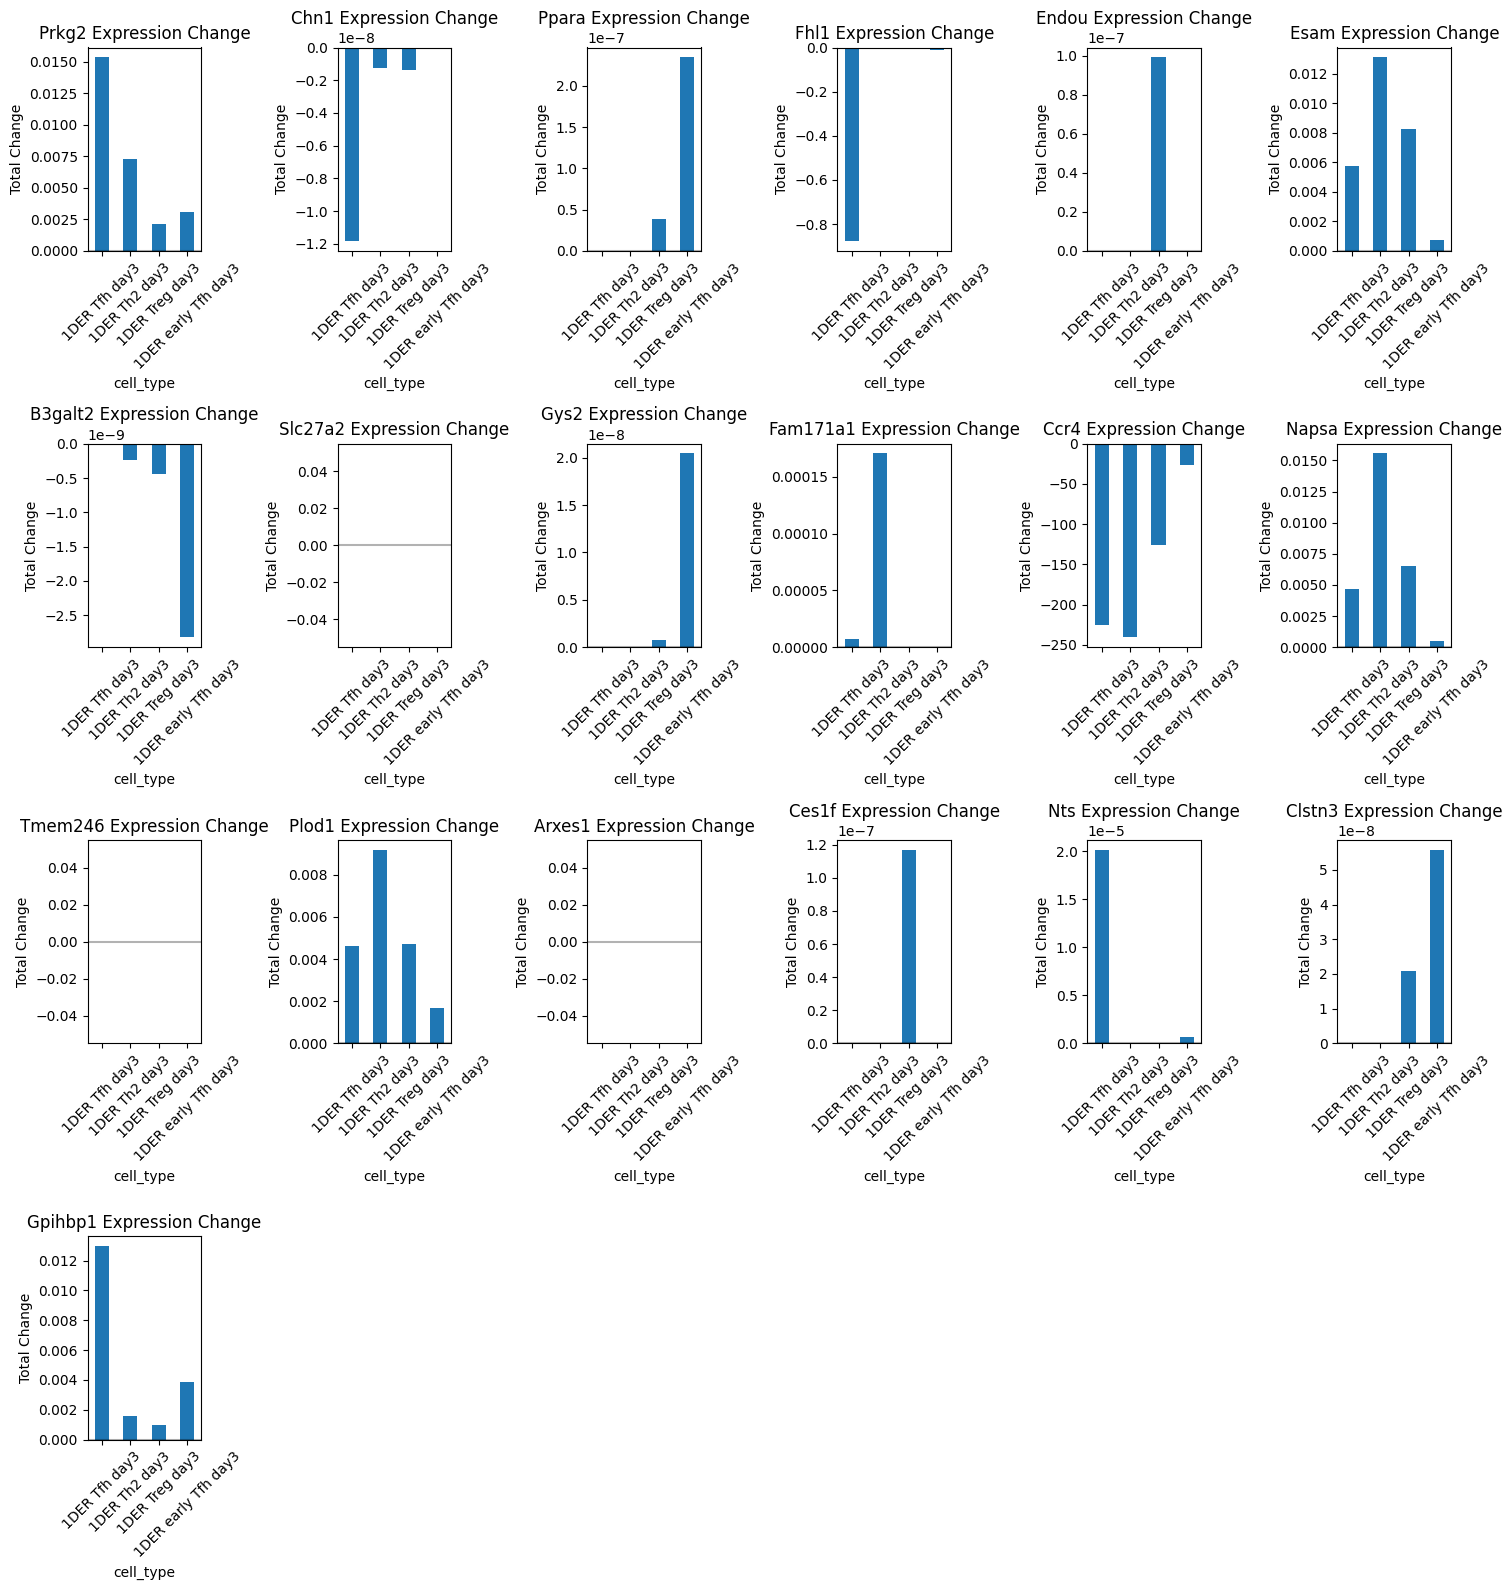

In [61]:
genestoplot = set(top_10_per_celltype.values.flatten())

# Create subplots for each gene
n_genes = len(genestoplot)
n_cols = 6
n_rows = (n_genes + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot each gene
for idx, gene in enumerate(genestoplot):
    # Get data for this gene
    gene_data = delta_coi.groupby('cell_type')[gene].sum()
    
    # Create bar plot
    ax = axes[idx]
    gene_data.plot(kind='bar', ax=ax)
    ax.set_title(f'{gene} Expression Change')
    ax.set_ylabel('Total Change')
    ax.tick_params(axis='x', rotation=45)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Remove any empty subplots
for idx in range(len(genestoplot), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


### Look at environment

/tmp/ipykernel_238034/2258402297.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_sums = delta_X.groupby('cell_type').sum()


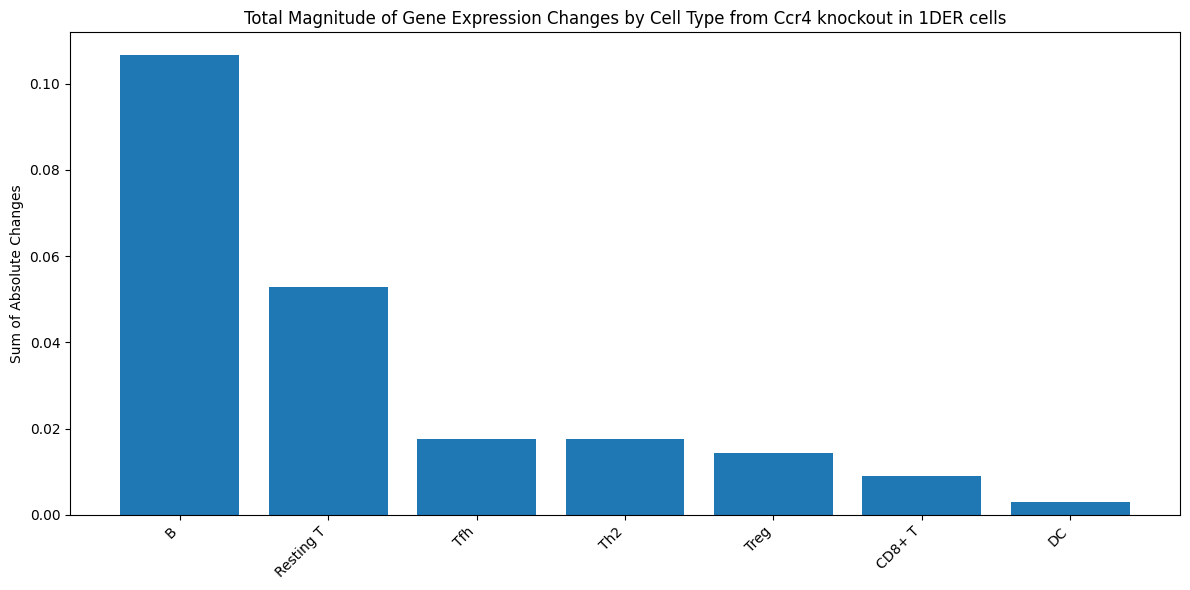


Detailed changes by cell type:


Adal  Adam11       Adamts1  Adamts12  Adamts15  Adamtsl1  Adat2  \
cell_type                                                                    
B           0.0     0.0  0.000000e+00       0.0       0.0       0.0    0.0   
CD8+ T      0.0     0.0  0.000000e+00       0.0       0.0       0.0    0.0   
DC          0.0     0.0 -2.696771e-12       0.0       0.0       0.0    0.0   
Resting T   0.0     0.0  0.000000e+00       0.0       0.0       0.0    0.0   
Tfh         0.0     0.0  0.000000e+00       0.0       0.0       0.0    0.0   
Th2         0.0     0.0  0.000000e+00       0.0       0.0       0.0    0.0   
Treg        0.0     0.0  0.000000e+00       0.0       0.0       0.0    0.0   

                  Adck2     Adcy4        Adgra2  ...       Zkscan6  Zkscan7  \
cell_type                                        ...                          
B          0.000000e+00  0.000000  2.432419e-08  ...  0.000000e+00      0.0   
CD8+ T     0.000000e+00  0.000000  0.000000e+00  ...  0.000000e+00      0.0   
DC         0.000000e+00  0.000000  0.000000e+00  ...  0.000000e+00      0.0   
Resting T  0.000000e+00  0.000000  0.000000e+00  ...  0.000000e+00      0.0   
Tfh        0.000000e+00  0.000000  0.000000e+00  ...  7.874283e-08      0.0   
Th2       -1.727283e-05 -0.000002  0.000000e+00  ... -1.277014e-05      0.0   
Treg      -3.694593e-08  0.000000  0.000000e+00  ...  0.000000e+00      0.0   

                  Zmym4        Zmynd8  Znrd1as    Zranb1        Zranb2  \
cell_type                                                                
B         -1.601354e-08 -4.392828e-08      0.0  0.000000  0.000000e+00   
CD8+ T     0.000000e+00  6.339292e-09      0.0  0.000000  4.296303e-09   
DC        -1.509877e-11  2.830329e-10      0.0  0.000060  2.014120e-10   
Resting T  0.000000e+00  0.000000e+00      0.0  0.000000 -4.988806e-08   
Tfh        0.000000e+00 -2.288955e-07      0.0 -0.000846 -8.864911e-08   
Th2       -2.891155e-07 -9.950157e-06      0.0 -0.000062  8.989145e-07   
Treg       0.000000e+00 -1.547160e-07      0.0  0.000000 -2.047435e-07   

           Zswim5    Zswim6        Zyg11b  
cell_type                                  
B             0.0  0.000000  0.000000e+00  
CD8+ T        0.0 -0.000495  1.899236e-08  
DC            0.0 -0.000007 -4.250476e-11  
Resting T     0.0  0.000194  0.000000e+00  
Tfh           0.0  0.000000  0.000000e+00  
Th2           0.0  0.000000  0.000000e+00  
Treg          0.0 -0.000713  0.000000e+00  

[7 rows x 3128 columns]

In [28]:
delta_X['cell_type'] = adata_train.obs['cell_type']
delta_X = delta_X.loc[adata_train.obs['1DER'] != True]
cell_type_sums = delta_X.groupby('cell_type').sum()

# Calculate total magnitude of change per cell type and get top 10 genes
cell_type_magnitudes = cell_type_sums.abs().sum(axis=1).sort_values(ascending=False)
top_10_genes = cell_type_sums.abs().sum(axis=0).sort_values(ascending=False).head(10)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(cell_type_magnitudes.index, cell_type_magnitudes.values)
plt.xticks(rotation=45, ha='right')
plt.title('Total Magnitude of Gene Expression Changes by Cell Type from Ccr4 knockout in 1DER cells')
plt.ylabel('Sum of Absolute Changes')
plt.tight_layout()
plt.show()

# Display the detailed changes
print("\nDetailed changes by cell type:")
display(cell_type_sums)

In [29]:
# Get top 10 genes with largest absolute changes for each cell type
top_10_per_celltype = pd.DataFrame()
for cell_type in cell_type_sums.index:
    top_10_genes = cell_type_sums.loc[cell_type].abs().nlargest(10)
    top_10_per_celltype[cell_type] = top_10_genes.index

display(top_10_per_celltype)

B  CD8+ T      DC Resting T     Tfh     Th2    Treg
0   Tmsb4x  Tmsb4x     Cfp    Tmsb4x  Tmsb4x  Tmsb4x  Tmsb4x
1    Napsa   Plbd1  Tmsb4x      Smc5  Mrpl57    Ly6d     Cfp
2     Cd55    Ly6d   Olfm1     Plod1    Ly6d  Prkag1    Phax
3     Ly6d    Cd55  Ifnar1      Pop5   Napsa  Ifnar1  Sema4d
4    Il21r  Zswim6  Col6a2      Cd55     Cfp    Smc5   Plbd1
5      Cfp    Pop5   Bcar1      Eri3  Zranb1  Mrpl57  Zswim6
6   Sppl2b    Esam  Recql5    Zswim6   Plbd1    Hscb    Rtp4
7     Ccr6  Txnrd2  Zbtb46      Ly6d    Phax    Cd55  Col6a2
8  Gpihbp1    Naca    Eri3    Golga5  Sema4d   Tipin   Napsa
9   Sema4d  Malat1  Prkag1      Oit1    Cd55   Tnnt1    Pop5

In [30]:
color_dict = {
    "B": "#9e18f1",
    "Resting T": "#a5b146",
    "Tfh": "#1032ee",
    "CD8+ T": "#9a6834",
    "Treg": "#5db852",
    "Th2": "#cd4263",
    "DC": "#5d6cb1"
}


In [31]:
from spaceoracle.plotting.cartography import Cartography

non_1der = adata_train[adata_train.obs['1DER'] == False].obs_names.tolist()

chart = Cartography(adata_train[non_1der], color_dict)

ModuleNotFoundError: No module named 'spaceoracle'

In [38]:
chart.adata.obs.head(3)

cell_type cell_type_int celltype_label_tangram  \
GGAAAACCCCGAGG    CD8+ T             1                 CD8+ T   
TTTTTTACATCATC      Treg             6               B | Treg   
TCAAGGAATGTGCT         B             0                      B   

               banksy_celltypes   1DER 1DER_cell_type  
GGAAAACCCCGAGG                4  False         CD8+ T  
TTTTTTACATCATC               11  False           Treg  
TCAAGGAATGTGCT                4  False              B

In [39]:
adata = chart.adata

In [ ]:
adata.obs['1DER'] = adata.obs['1DER'].map({True: '1DER', False: 'non-1DER'})

In [53]:
adata.obs['1DER'].value_counts()

1DER
non-1DER    21597
Name: count, dtype: int64

In [147]:
from spaceoracle.models.parallel_estimators import create_spatial_features

spf = create_spatial_features(
    x=adata_train.obsm['spatial'][:, 0], 
    y=adata_train.obsm['spatial'][:, 1], 
    celltypes=adata_train.obs['1DER_cell_type'],
    obs_index=adata_train.obs_names
)

spf.head(3)

1DER Tfh day3_within  1DER Th2 day3_within  \
GGAAAACCCCGAGG                   1.0                   1.0   
TTTTTTACATCATC                   3.0                   5.0   
TCAAGGAATGTGCT                   0.0                   3.0   

                1DER Treg day3_within  1DER early Tfh day3_within  B_within  \
GGAAAACCCCGAGG                    0.0                         0.0      89.0   
TTTTTTACATCATC                    3.0                         2.0      44.0   
TCAAGGAATGTGCT                    1.0                         0.0     128.0   

                CD8+ T_within  DC_within  Resting T_within  Tfh_within  \
GGAAAACCCCGAGG           69.0        2.0              60.0        23.0   
TTTTTTACATCATC           62.0        1.0              63.0        29.0   
TCAAGGAATGTGCT           22.0        1.0              38.0        15.0   

                Th2_within  Treg_within  
GGAAAACCCCGAGG         2.0         24.0  
TTTTTTACATCATC        11.0         35.0  
TCAAGGAATGTGCT         6.0         11.0

In [148]:
cell_groups = {
    '1DER': ['1DER Tfh day3', '1DER Th2 day3', '1DER Treg day3', '1DER early Tfh day3'],
    '1DER_Tfh' : ['1DER Tfh day3'],
    '1DER_Th2' : ['1DER Th2 day3'],
    '1DER_Treg' : ['1DER Treg day3'],
    '1DER_early_Tfh' : ['1DER early Tfh day3'],
    'B': ['B'],
    'CD8+ T': ['CD8+ T'],
    'DC': ['DC'],
    'Resting T': ['Resting T'],
    'Tfh': ['Tfh'],
    'Th2': ['Th2'],
    'Treg': ['Treg'],
}


In [149]:
spf

1DER Tfh day3_within  1DER Th2 day3_within  \
GGAAAACCCCGAGG                   1.0                   1.0   
TTTTTTACATCATC                   3.0                   5.0   
TCAAGGAATGTGCT                   0.0                   3.0   
CGATGTGAATCTAC                   5.0                   0.0   
CATCGGACTAGCCC                   9.0                   0.0   
...                              ...                   ...   
TGGACCGTGACAGA                   0.0                   0.0   
CTTTCTTCTGTACT                   0.0                   0.0   
CTCCATGGCATTCC                   1.0                   0.0   
CGCGGACCTCGCGC                   1.0                   0.0   
AGCCTGGTATTGGT                   0.0                   0.0   

                1DER Treg day3_within  1DER early Tfh day3_within  B_within  \
GGAAAACCCCGAGG                    0.0                         0.0      89.0   
TTTTTTACATCATC                    3.0                         2.0      44.0   
TCAAGGAATGTGCT                    1.0                         0.0     128.0   
CGATGTGAATCTAC                    0.0                         1.0     219.0   
CATCGGACTAGCCC                    0.0                         0.0     299.0   
...                               ...                         ...       ...   
TGGACCGTGACAGA                    0.0                         2.0      82.0   
CTTTCTTCTGTACT                    0.0                         2.0      76.0   
CTCCATGGCATTCC                    0.0                         1.0     107.0   
CGCGGACCTCGCGC                    0.0                         2.0     105.0   
AGCCTGGTATTGGT                    0.0                         2.0      85.0   

                CD8+ T_within  DC_within  Resting T_within  Tfh_within  \
GGAAAACCCCGAGG           69.0        2.0              60.0        23.0   
TTTTTTACATCATC           62.0        1.0              63.0        29.0   
TCAAGGAATGTGCT           22.0        1.0              38.0        15.0   
CGATGTGAATCTAC            8.0        0.0               7.0        10.0   
CATCGGACTAGCCC            3.0        0.0               0.0         5.0   
...                       ...        ...               ...         ...   
TGGACCGTGACAGA            0.0        0.0               6.0         2.0   
CTTTCTTCTGTACT            0.0        0.0               4.0         1.0   
CTCCATGGCATTCC            1.0        0.0               6.0         3.0   
CGCGGACCTCGCGC            1.0        0.0               6.0         2.0   
AGCCTGGTATTGGT            0.0        0.0               5.0         1.0   

                Th2_within  Treg_within  
GGAAAACCCCGAGG         2.0         24.0  
TTTTTTACATCATC        11.0         35.0  
TCAAGGAATGTGCT         6.0         11.0  
CGATGTGAATCTAC         0.0          8.0  
CATCGGACTAGCCC         1.0          3.0  
...                    ...          ...  
TGGACCGTGACAGA         0.0          0.0  
CTTTCTTCTGTACT         0.0          1.0  
CTCCATGGCATTCC         0.0          0.0  
CGCGGACCTCGCGC         0.0          0.0  
AGCCTGGTATTGGT         0.0          1.0  

[22227 rows x 11 columns]

In [165]:
import os 
from scipy.stats import pearsonr
from spaceoracle.plotting.cartography import xy_from_adata

xy = xy_from_adata(adata)

def plot_gene_vs_proximity(perturb_target, gene, color_gene, cell_filter, proximity_cell,
                           spf, perturbed_df, adata, mode='KO', proximity_threshold=500, ax=None):
    
    datadf = spf[
        [i+'_within' for i in cell_groups[proximity_cell]
            ]].sum(1).to_frame().join(adata.obs.cell_type).query(
             f'cell_type.isin(["{cell_filter}"])').join(xy).join(
        ((perturbed_df-adata.to_df(layer='imputed_count'))/adata.to_df(layer='imputed_count'))*100
    )
    datadf = datadf[datadf[0] < proximity_threshold]

    if ax is None:
        ax = plt.gca()
    try:
        corr = pearsonr(datadf[0], datadf[gene].values).statistic
        ax.set_title(f"{perturb_target} {mode.upper()} in\n{cell_filter}\nCorrelation: {corr:.4f}")
    except:
        corr = 0
        ax.set_title(f"{perturb_target} {mode.upper()} in\n{cell_filter}")
        

    scatter = ax.scatter(
        datadf[0], 
        datadf[gene], 
        c=datadf[color_gene],
        cmap='rainbow',
    )
    plt.colorbar(scatter, label=f'{color_gene} % change', shrink=0.75, ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(f'{gene} % change')
    ax.set_xlabel(f'Number of {proximity_cell} within 200um')
    
    return ax, datadf

In [158]:
adata.obs['cell_type'].unique(), cell_groups.keys()

(['CD8+ T', 'Treg', 'B', 'Resting T', 'Tfh', 'Th2', 'DC']
 Categories (7, object): ['B', 'CD8+ T', 'DC', 'Resting T', 'Tfh', 'Th2', 'Treg'],
 dict_keys(['1DER', '1DER_Tfh', '1DER_Th2', '1DER_Treg', '1DER_early_Tfh', 'B', 'CD8+ T', 'DC', 'Resting T', 'Tfh', 'Th2', 'Treg']))

In [32]:
perturbed_df=simulated_gex.loc[transferred]
perturb_target='Ccr4'
proximity_cell='B'
gene='Ccl17'
color_gene='Ccl5'
cell_filter='CD8+ T'

NameError: name 'adata' is not defined

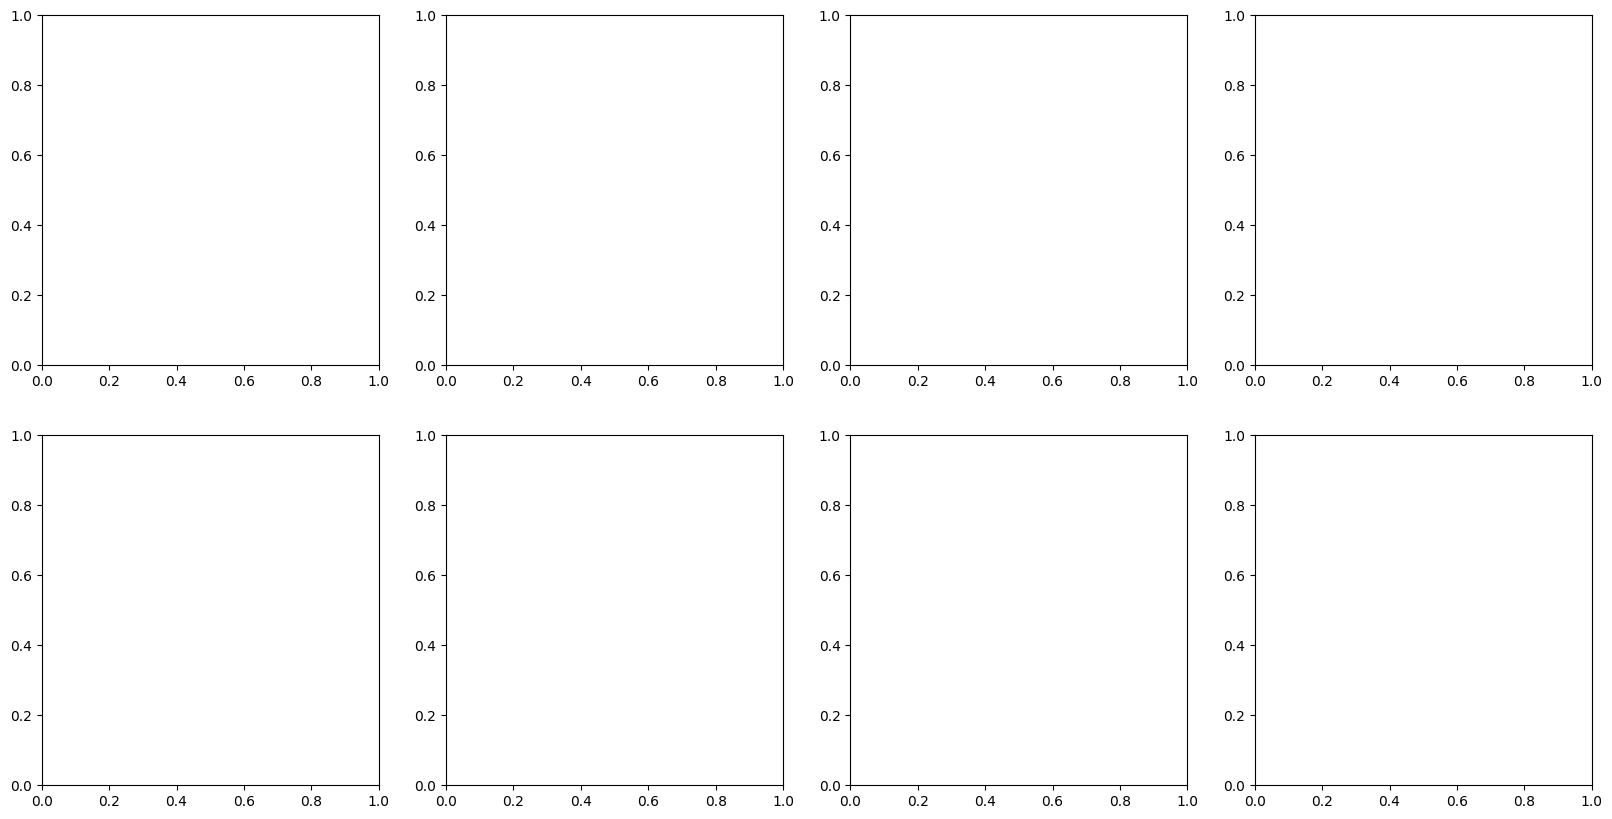

In [33]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, ct in enumerate(adata.obs['cell_type'].unique()):
    ax, datadf = plot_gene_vs_proximity(
        adata=adata_train,
        perturbed_df=simulated_gex.loc[transferred],
        spf=spf.loc[transferred],
        perturb_target='Ccr4', 
        proximity_cell='B',
        gene='Ccl17', color_gene='Ccl5',
        cell_filter=ct,
        ax=axes[i]
    )

# Remove unused axes
for i in range(len(adata.obs['cell_type'].unique()), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


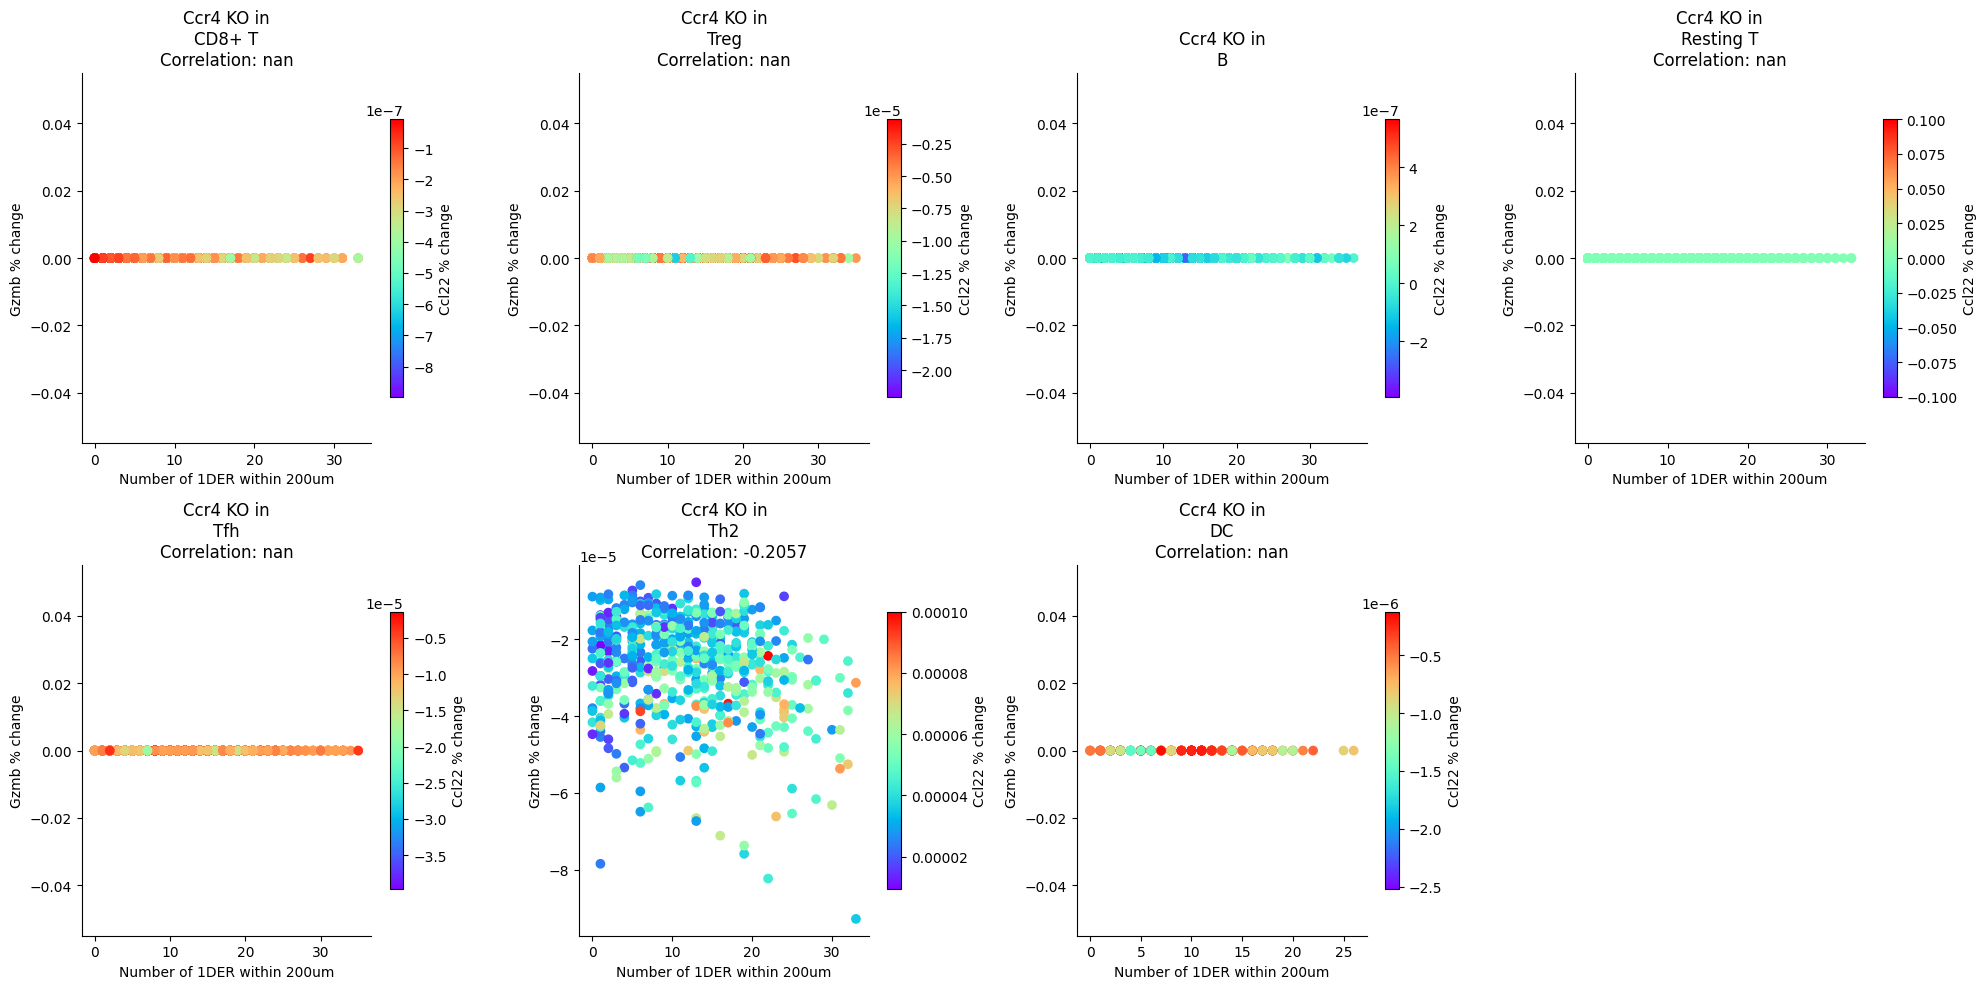

In [122]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, ct in enumerate(adata.obs['cell_type'].unique()):
    ax, datadf = plot_gene_vs_proximity(
        perturbed_df=simulated_gex.loc[non_1der],
        spf=spf.loc[non_1der],
        perturb_target='Ccr4', 
        proximity_cell='1DER',
        gene='Gzmb', color_gene='Ccl22',
        cell_filter=ct,
        ax=axes[i]
    )

# Remove unused axes
for i in range(len(adata.obs['cell_type'].unique()), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### Flipping dots

In [152]:
import sys 
sys.path.append('/ix3/djishnu/alw399/SpaceOracle/src')

In [153]:
# del adata_train.uns['received_ligands']
# del adata_train.uns['received_ligands_tfl']

# adata_train.uns['cell_thresholds'] = pd.DataFrame(
#     index=adata_train.obs.index, 
#     columns=adata_train.var_names).fillna(1)


### Flipping dots

In [154]:
from spaceoracle.plotting.cartography import Cartography

In [215]:
color_dict = {
    "B": "#9e18f1",
    "Resting T": "#a5b146",
    "Tfh": "#1032ee",
    "CD8+ T": "#9a6834",
    "Treg": "#5db852",
    "Th2": "#cd4263",
    "DC": "#5d6cb1"
}

subset_1der = '1DER Tfh day3'
# subset_1der = '1DER Th2 day3'

chart = Cartography(
    # adata_train[transferred], 
    adata_train[adata_train.obs['1DER_cell_type'].isin([subset_1der])],
    color_dict=color_dict
)

In [216]:
chart.adata.obs['1DER_cell_type'].value_counts()

1DER_cell_type
1DER Tfh day3    229
Name: count, dtype: int64

In [217]:
# only when using all transferred cells
# chart.adata.obs['banksy_celltypes'] = chart.adata.obs['1DER_cell_type']

In [218]:
# embedding = adata.obsm['X_umap']
# embedding = adata_train.obsm['X_spatial']

# corr = chart.compute_perturbation_corr(gene_mtx, delta_X, embedding=embedding, k=300)
# null_corr =  chart.compute_perturbation_corr(gene_mtx, delta_X * 0, embedding=embedding, k=300)
# corr.shape

In [219]:
gene_mtx = adata_train.to_df(layer='imputed_count')
delta_X = simulated_gex - gene_mtx
delta_X.shape

(22227, 3128)

In [220]:
subset_cells = adata_train[adata_train.obs['1DER_cell_type'] == subset_1der].obs.index
gene_mtx = gene_mtx.loc[subset_cells]
delta_X = delta_X.loc[subset_cells]

# corr = chart.compute_perturbation_corr(gene_mtx, delta_X)
# null_corr = chart.compute_perturbation_corr(gene_mtx, delta_X * 0)
# corr.shape

In [221]:
import alphashape
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 
from shapely.geometry import Point

In [222]:
chart.adata

View of AnnData object with n_obs × n_vars = 229 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram', 'banksy_celltypes', '1DER', '1DER_cell_type', 'x', 'y'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count', 'simulated_count'

In [223]:
sc.tl.pca(chart.adata)
sc.pp.neighbors(chart.adata)
sc.tl.umap(chart.adata)

In [224]:
P = chart.compute_transition_probabilities(
    delta_X, 
    embedding=chart.adata.obsm['X_umap'])
P.shape

(229, 229)

In [225]:
try:
    chart.adata.obs.drop(['transition'], axis=1, inplace=True)
except:
    pass

chart.get_transition_annot(
    # corr - null_corr, 
    P,
    allowed_fates=chart.adata.obs['banksy_celltypes'].unique(), 
    thresh=0, 
    annot='banksy_celltypes'
)

source ct 9 Counter({'9': 28, '15': 8, '0': 4, '7': 3, '22': 1}) 0.00310360870817346 0.0020024835899403997
source ct 0 Counter({'9': 71, '15': 34, '0': 4, '7': 3, '22': 2}) 0.0033035443257134335 0.001389914627322848
source ct 2 Counter({'15': 26, '22': 5, '9': 4, '7': 1, '0': 1}) 0.002738416349643067 0.0005943642908690515
source ct 11 Counter({'15': 6, '22': 1}) 0.004399028491116131 0.0
source ct 4 Counter({'15': 4, '9': 2}) 0.0028042768325845097 0.0007319543620241419
source ct 7 Counter({'9': 7, '15': 6, '7': 2, '22': 1}) 0.003505511726147946 0.0019262800899781227
source ct 13 Counter({'15': 1, '22': 1, '9': 1}) 0.0037055082407469815 0.0
source ct 15 Counter({'9': 1}) 0.0032084879398072436 0.0
source ct 22 Counter({'15': 1}) 0.004390834910760092 0.0


In [226]:
adata = chart.adata

In [227]:
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [228]:
ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='banksy_celltypes')
ct_points_wt, ct_points_ko

({'9': array([[-1445.43564467,  4307.07088448],
         [-1522.7374183 ,  4434.04566094],
         [-1144.36042241,  3081.99943013],
         [-1180.41498856,  2914.16934366],
         [-1274.2744298 ,  2293.20782113],
         [-1651.67168205,  1872.89779721],
         [-1805.68738313,  1772.27812481],
         [-1849.18800099,  1618.85026993],
         [-1888.57369554,  1611.79611568],
         [-1983.80477788,  1541.45052193],
         [-2526.97465495,  1164.5431415 ],
         [-3053.48889005,  4132.77448995],
         [-3253.25861937,  4038.03327943],
         [-3688.65669544,  3834.05065243],
         [-3717.75508171,  3682.6802592 ],
         [-3759.29621228,  3670.72738672],
         [-3915.17342628,  3492.02214578],
         [-3947.01509476,  3281.76915945],
         [-4147.47064463,  3103.25986724],
         [-4118.96010454,  3093.36445642],
         [-2956.69021787,  1235.77050453],
         [-3038.9886841 ,  1239.59150475],
         [-3185.75428219,  1323.26161208],
      

In [229]:
colors = ["#a24467",
"#64ac48",
"#815ec9",
"#9a963f",
"#cd49a3",
"#4aac8b",
"#ca4938",
"#618bcc",
"#c88341",
"#c584c8",
"#dd6f7e"]

color_dict = {ct: colors[i] for i, ct in enumerate(adata_train.obs['banksy_celltypes'].unique())}
color_dict

{'4': '#a24467',
 '11': '#64ac48',
 '0': '#815ec9',
 '9': '#9a963f',
 '7': '#cd49a3',
 '13': '#4aac8b',
 '20': '#ca4938',
 '15': '#618bcc',
 '22': '#c88341',
 '2': '#c584c8',
 '17': '#dd6f7e'}

In [230]:
adata_train.obs['x'] = adata_train.obsm['spatial'][:, 0]
adata_train.obs['y'] = adata_train.obsm['spatial'][:, 1]


In [212]:
# fig, ax = plt.subplots(figsize=(20, 9), dpi=120)


# alpha_shapes = {}

# for ct in adata.obs['banksy_celltypes'].unique():
#     if ct in ct_points_wt:
#         alpha_shapes[ct] = alphashape.alphashape(ct_points_wt[ct], alpha=0.05)

# for ct in adata_train.obs['banksy_celltypes'].unique():
#     sns.scatterplot(
#         data=adata_train[adata_train.obs['banksy_celltypes'] == ct].obs,
#         x='x', y='y',
#         color=color_dict[ct], alpha=0.5,
#     )

# zone_alpha = 0.7
# area_thresh = 0

# for cluster, alpha_shape in alpha_shapes.items():
#     try:
#         for geom in alpha_shape.geoms:
#             if geom.area > area_thresh:
#                 ax.fill(
#                     geom.exterior.xy[0], 
#                     geom.exterior.xy[1], 
#                     color=color_dict[str(cluster)], alpha=zone_alpha)
#     except:
#         geom = alpha_shape
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict[str(cluster)], alpha=zone_alpha
#         )

# for ct in range(0, max(adata.obs['banksy_celltypes'].unique().astype(int))):
#     ct = str(ct)
#     if ct not in adata.obs['banksy_celltypes'].unique():
#         continue
#     ax.scatter(
#         adata[adata.obs['banksy_celltypes'] == ct].obsm['spatial'][:, 0],
#         adata[adata.obs['banksy_celltypes'] == ct].obsm['spatial'][:, 1],
#         c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
#         label=f'{ct} | {len(adata[adata.obs["banksy_celltypes"] == ct].obs_names)}'
#     )

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
# ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
# plt.tight_layout()

# plt.savefig(f'slideseq_mouse_lymph_Ccr6KO_preKO_{subset_1der}.svg', format='svg', transparent=True, bbox_inches='tight')
# # plt.savefig(f'slideseq_mouse_lymph_Ccr4KO_preKO_{subset_1der}.svg', format='svg', transparent=True, bbox_inches='tight')

In [213]:
# alpha_shapes = {}

# for ct in adata.obs['1DER_cell_type'].unique():
#     if ct in ct_points_ko:
#         alpha_shapes[ct] = alphashape.alphashape(ct_points_ko[ct], alpha=0.5)

# fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

# for ct in adata_train.obs['banksy_celltypes'].unique():
#     sns.scatterplot(
#         data=adata_train[adata_train.obs['banksy_celltypes'] == ct].obs,
#         x='x', y='y',
#         color=color_dict[ct], alpha=0.5
#     )

# zone_alpha = 0.7
# area_thresh = 150

# for cluster, alpha_shape in alpha_shapes.items():
#     try:
#         for geom in alpha_shape.geoms:
#             if geom.area > area_thresh:
#                 ax.fill(
#                     geom.exterior.xy[0], 
#                     geom.exterior.xy[1], 
#                     color=color_dict[str(cluster)], alpha=zone_alpha)
#     except:
#         geom = alpha_shape
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict[str(cluster)], alpha=zone_alpha
#         )

# for ct in range(0, max(adata.obs['transition'].unique().astype(int))):
#     ct = str(ct)
#     if ct not in adata.obs['transition'].unique():
#         continue
#     ax.scatter(
#         adata[adata.obs['transition'] == ct].obsm['spatial'][:, 0],
#         adata[adata.obs['transition'] == ct].obsm['spatial'][:, 1],
#         c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
#         label=f'{ct} ({len(adata[adata.obs["transition"] == ct].obs_names)})'
#     )

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
# ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
# plt.tight_layout()

# # plt.savefig(f'slideseq_mouse_lymph_Ccr4KO_{subset_1der}.svg', format='svg', transparent=True, bbox_inches='tight')

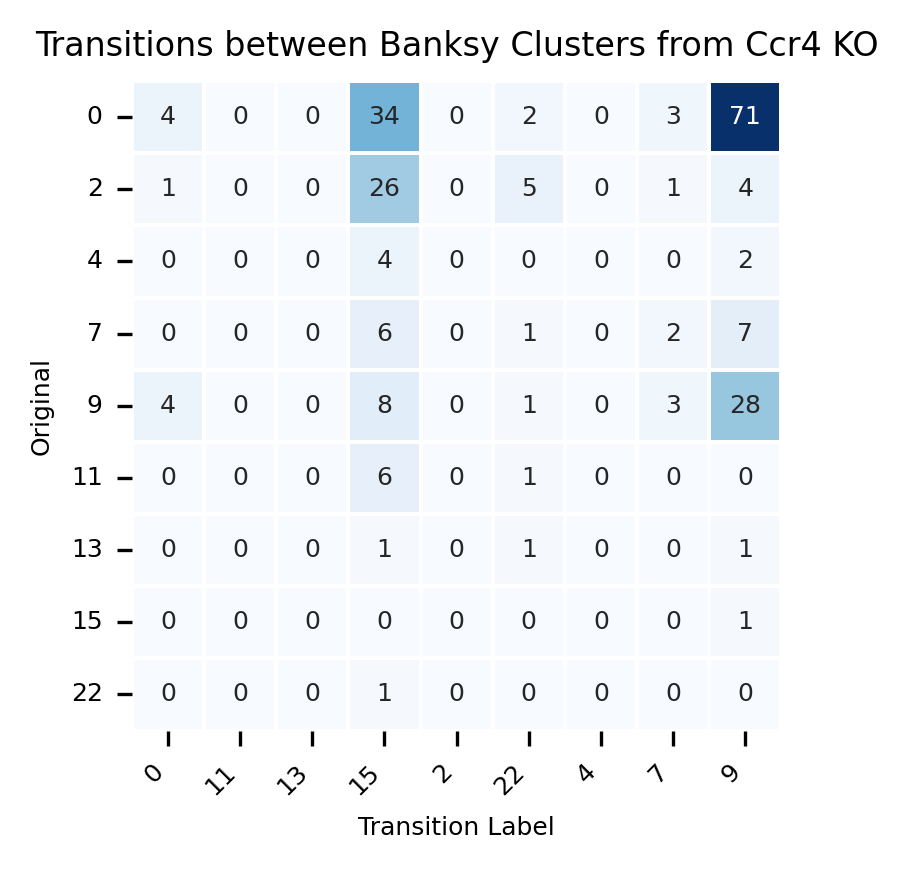

In [231]:
df = chart.adata.obs[['banksy_celltypes', 'transition']].copy()
counts = df.groupby(['banksy_celltypes', 'transition']).size().unstack(fill_value=0)

plt.figure(figsize=(3,3), dpi=300)

# Ensure counts has same number of rows and columns
if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

counts = counts.loc[np.unique([int(x) for x in counts.index]).astype(str)] 

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)

plt.title(f"Transitions between Banksy Clusters from Ccr4 KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig(f'slideseq_mouse_lymph_Ccr4KO_transitions_1DER_Tfh.svg', format='svg', bbox_inches='tight', transparent=True)
plt.show()

In [52]:
relative_change = (simulated_gex.loc[subset_cells] - gene_mtx.loc[subset_cells]) / gene_mtx.loc[subset_cells]
relative_change.replace([np.inf, -np.inf], np.nan, inplace=True)
relative_change.fillna(0, inplace=True)
relative_change.mean(axis=0).sort_values(key=abs, ascending=False).head(25).index

Index(['Ccr6', 'Napsa', 'Esam', 'Ly6d', 'Col6a2', 'Plod1', 'Zfyve21', 'Prkg2',
       'Oit1', 'Cfp', 'Tle6', 'Cd55', 'Cfd', 'Olfm1', 'Slc9a7', 'Fhl1',
       'Zranb1', 'Sppl2b', 'Msra', 'Bcar1', 'Smc5', 'Mrpl57', 'Hscb', 'Rtp4',
       'Tnnt1'],
      dtype='object')

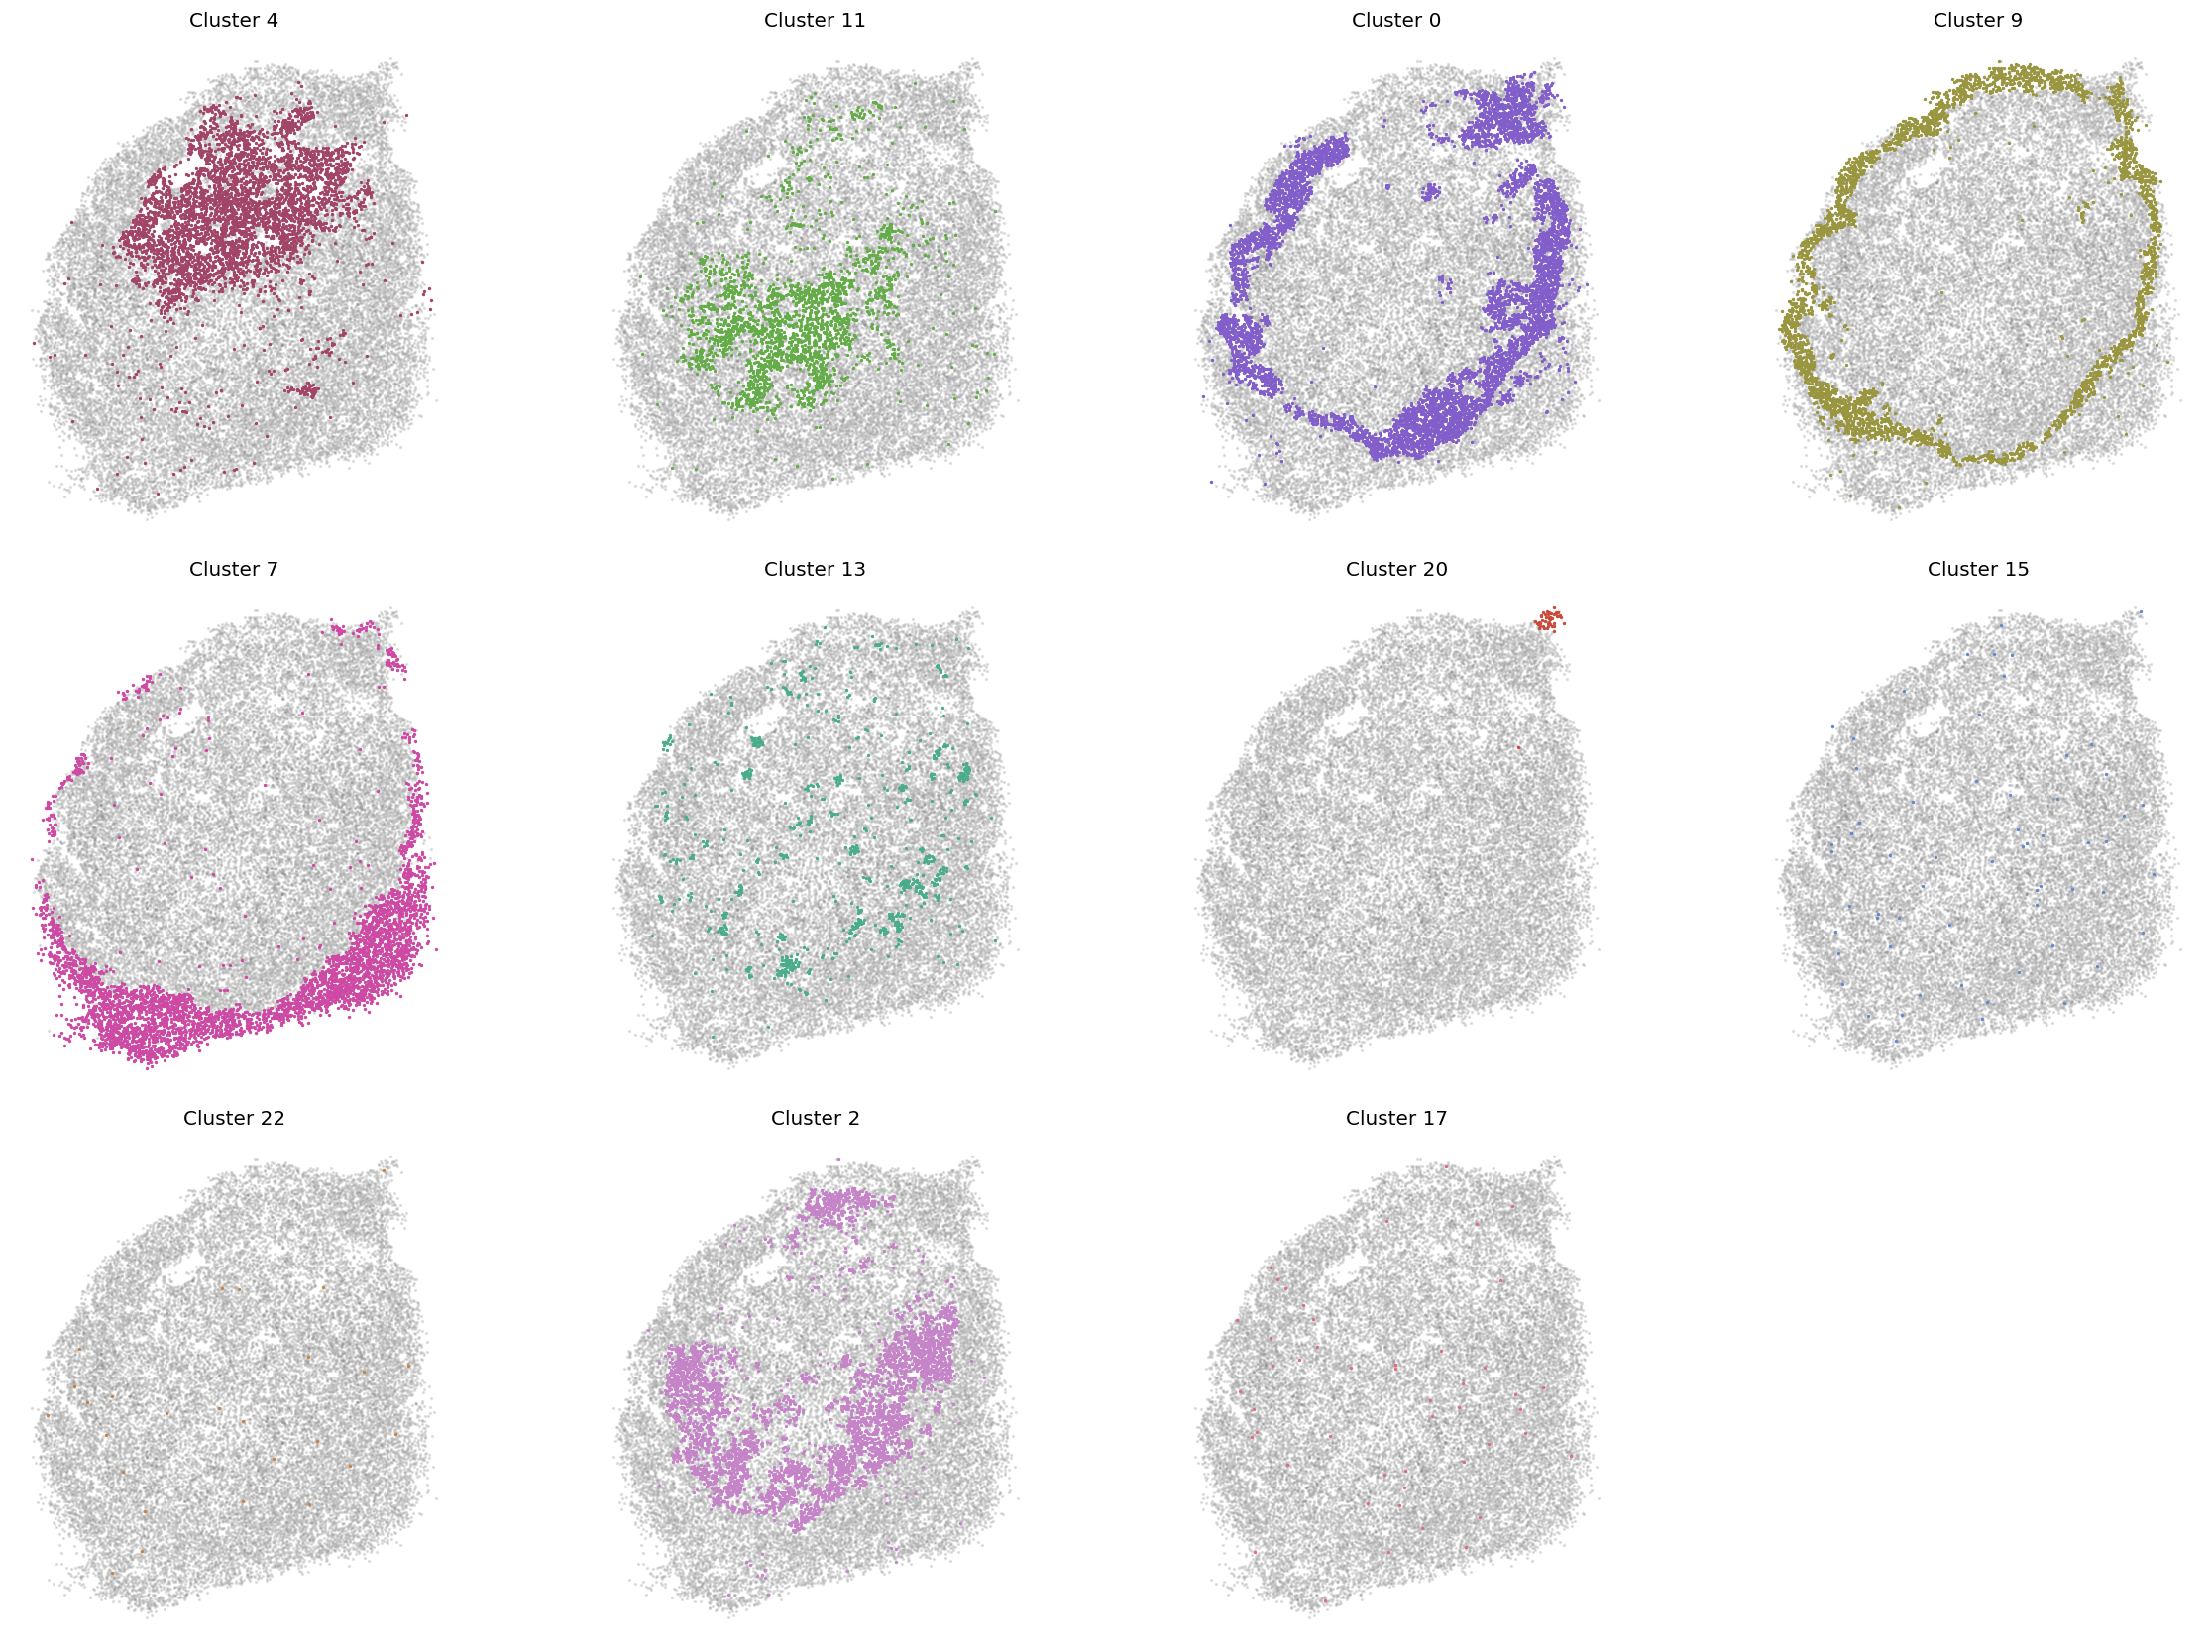

In [56]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14), dpi=120)
axes = axes.flatten()

# Plot all cells in gray first
for ax in axes:
    ax.scatter(adata_train.obsm['spatial'][:, 0], 
              adata_train.obsm['spatial'][:, 1],
              c='gray', alpha=0.2, s=1)

# Plot each cluster in its color
for idx, cluster in enumerate(adata_train.obs['banksy_celltypes'].unique()):
    mask = adata_train.obs['banksy_celltypes'] == cluster
    axes[idx].scatter(adata_train.obsm['spatial'][mask, 0],
                        adata_train.obsm['spatial'][mask, 1],
                        c=color_dict[cluster], s=1)
    axes[idx].set_title(f'Cluster {cluster}')
    axes[idx].axis('off')
    axes[idx].set_aspect('equal')

# Remove unused axes
for idx in range(len(adata_train.obs['banksy_celltypes'].unique()), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(f'slideseq_mouse_lymph_Ccr6KO_banksy.svg', format='svg', transparent=True, bbox_inches='tight')

In [151]:
# lectin gene dotplot to show Ccr4 migration

migration_markers = [
    "Cd302",      # hDCL-1
    "Clec4a2",    # C-type lectin domain family 4 member A2
    "Itgam"       # CD11b - integrin alpha M, myeloid migration marker
]

migration_markers = [x for x in migration_markers if x in adata_train.var_names]

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


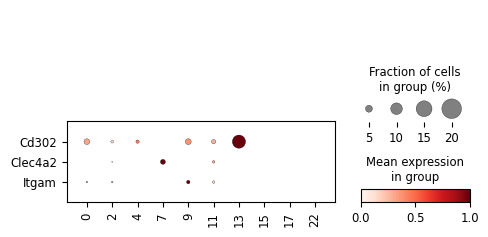

In [152]:
sc.pl.dotplot(
    adata_train[transferred], 
    migration_markers, 
    groupby='banksy_celltypes',
    standard_scale='var',
    swap_axes=True,
)

### LR terms that promote Th2/ Tfh identity